In [37]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats.stats import pearsonr, ttest_ind
from glob import glob
plt.rcParams["font.family"] = ["Times New Roman"]


/tmp/ipykernel_1693379/3223969906.py:8: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr, ttest_ind
/tmp/ipykernel_1693379/3223969906.py:8: DeprecationWarning: Please import `ttest_ind` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr, ttest_ind


In [ ]:
def agg1(params, param_of_interest):
    params = params.sort_index()
    params["config"] = ["Vanilla", "Bayes prior", "Binary Prior"]
    param_of_interest = "config"
    return params, param_of_interest
def agg2(params, param_of_interest):
    params = params.sort_index()
    return params, param_of_interest
def agg3(params, param_of_interest):
    params = params.sort_index()
    params["Config"] = ["Vanilla\n5 TFs", "Masking\n5 TFs", "Vanilla\n10 TFs", "Masking\n10 TFs"]
    params = params.iloc[[0,2,1,3]]
    param_of_interest = "Config"
    return params, param_of_interest
def agg4(params, param_of_interest):
    params = params.sort_values(param_of_interest)
    params["Config"] = ["Vanilla\n400", "Masking\n400", "Masking\n200", "Masking\n100", "Vanilla\n200", "Vanilla\n100"]
    param_of_interest = "Config"
    params = params.sort_values("Config")
    return params, param_of_interest
def agg5(params, param_of_interest):
    params = params.sort_values(param_of_interest)
    if len(params)>4:
        params["pert. factor"] = (1/10**np.arange(4, -1,-1)).astype(str)
    else:
        params["pert. factor"] = 1/np.arange(4, 0,-1)

    param_of_interest = "pert. factor"
    params=params.sort_values(param_of_interest)
    return params, param_of_interest
def agg6(params, param_of_interest):
    params[param_of_interest] = params[param_of_interest].astype(float)
    params = params.sort_values(param_of_interest)
    return params, param_of_interest
def agg7(params, param_of_interest):
    params = params.sort_index()
    params["config"] = ["Vanilla_old","Vanilla", "Bayes prior", "Binary Prior"]
    param_of_interest = "config"
    return params, param_of_interest
def agg8(params, param_of_interest):
    params = params.sort_index()
    params["config"] = params["data_id"]+params["masking_mode"]
    param_of_interest = "config"
    return params, param_of_interest
def agg_paper(params, param_of_interest):
    params = params.sort_index()
    params["config"] = params[param_of_interest] + " + " + params["masking_mode"]
    param_of_interest = "config"
    return params, param_of_interest
def agg(params, param_of_interest):
    params = params.sort_index()
    if type(param_of_interest) is dict:
        params["config"] = params[param_of_interest["0"]] + " + " + params[param_of_interest["1"]]
        index = params.isna()["config"]
        params.loc[index,"config"] = params.loc[index, param_of_interest["0"]]
        param_of_interest = "config"
        params.sort_values(param_of_interest)
    return params, param_of_interest

functions = {
    "agg1":agg1,
    "agg2":agg2,
    "agg3":agg3,
    "agg4":agg4,
    "agg5":agg5,
    "agg6":agg6,
    "agg7":agg7,
    "agg8":agg8,
    "agg_paper":agg_paper,
    "agg": agg,
             }
# get environment
with open("./data/experiment_configs.json", "r") as rf:
    config_sets = json.load(rf)

experiment = "bin"
config_set = config_sets[experiment]
include = config_set["include"]
id_len = config_set["id_len"]
prefix = config_set["prefix"]
param_of_interest = config_set["param_of_interest"]
agg = config_set["function"]

include = [4,12]
id_len = 3
prefix = "tuner_run_"
experiment = None
param_of_interest = "masking_loss"
agg = None
print(f"Experiment: {experiment}")
models_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/")
plot_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/plots")
data_path = Path("./data/")
columns = [
    "model_n_genes",
    "model_n_samples",
    "scale_mask",
    "grn_noise_p",
    "n_epochs",
    "use_hard_mask",
    "masking_mode",
    "bin_prior",
    "data_source",
    "mask_precision",
    "metric",
    ]
if not param_of_interest in columns and not type(param_of_interest) is dict:
    columns.append(param_of_interest)
    print(f"Adding {param_of_interest}")
elif isinstance(param_of_interest, dict):
     for item in param_of_interest.values():
        if item not in columns:
            columns.append(item)

results = dict()
params = pd.DataFrame(columns=columns)

for dir in models_path.iterdir():
    if dir.name[:-id_len] != prefix:
         continue
    if int(dir.name[-id_len:]) not in include:
          continue
    print(dir.name)
    if not (dir/"tune_results").exists():
        print(f"No tune results for {dir}")
        continue


    try:
        globs = pd.read_csv(dir/ "globals.csv", delimiter=",").set_index("0", drop=True).T
        available_paras = [n for n in columns if n in globs.columns]
        params.loc[dir.name] = globs[available_paras].iloc[1]
    except FileNotFoundError:
        print(f"globals file for {dir.name} not found!")
        params.loc[dir.name] = np.nan
    
    res = pd.read_csv(dir/"results_df.csv", index_col=0)
    res = res.dropna(axis=1, how="all")
    res = res[~res["final_nll"].isna()].sort_values("final_nll")
    res.columns = [c.split("/")[-1] if "/" in c else c for c in res.columns]
    res = res.set_index("logdir")

    results[dir.name.__str__()] = res

params = params.sort_index()
if agg != None:
     params, param_of_interest = functions[agg](params, param_of_interest)

'''    with torch.no_grad():
        grn = model.gt_beta.copy()
        ckpts[key]["grn"] = grn
        if not model.mask is None:
            beta = np.zeros(grn.shape)
            beta[model.mask.cpu().to(bool)] = model.beta_val
            ckpts[key]["beta"] = beta
            #plt.hist(beta)
            #plt.show()

        else:
            ckpts[key]["beta"] = model.beta.detach().cpu().numpy().copy()
        if not model.bayes_prior is None:
            ckpts[key]["prior"] = model.bayes_prior.cpu().numpy().copy()
'''

Experiment: None
Adding masking_loss
tuner_run_007
tuner_run_012


'    with torch.no_grad():\n        grn = model.gt_beta.copy()\n        ckpts[key]["grn"] = grn\n        if not model.mask is None:\n            beta = np.zeros(grn.shape)\n            beta[model.mask.cpu().to(bool)] = model.beta_val\n            ckpts[key]["beta"] = beta\n            #plt.hist(beta)\n            #plt.show()\n\n        else:\n            ckpts[key]["beta"] = model.beta.detach().cpu().numpy().copy()\n        if not model.bayes_prior is None:\n            ckpts[key]["prior"] = model.bayes_prior.cpu().numpy().copy()\n'

In [39]:
save = True

In [40]:
def get_log_path(logdir : str, id:str):
    dir = models_path/id/"tune_results"
    dir /= dir.glob("train_bicycle*").__next__()
    p = "train_bicycle_" + logdir
    possible_paths = dir.glob(p+"*")
    return possible_paths.__next__()
def extract_json_results(dir):
    with open(dir/"result.json", "r") as rf:
        result = pd.read_json(rf.readline())
        for line in rf.readlines():
            line = pd.read_json(line)
            result = pd.concat([result, line], axis=0)
    return result.reset_index(drop=True)

In [ ]:
from matplotlib.ticker import ScalarFormatter

def complete_result(d : pd.Series, id:str):
    p = get_log_path(d.name, id=id)
    res = extract_json_results(p)
    cols = d[d.isna()].index
    matches = [c for c in cols if c in res.columns]
    res = res[matches+["training_iteration"]].dropna(axis=0, how="any")
    last_res = res.loc[[res["training_iteration"].idxmax()], :]
    # Ensure shapes match for assignment
    d.loc[matches] = last_res[matches].iloc[0].values
    return d

def plot_training(d:pd.Series, id :str, axes = None, table_scale=(1,3), colors=["salmon", "skyblue"], figsize=(10,5)):
    p = get_log_path(d.name, id=id)
    res = extract_json_results(p)
    if axes is None:
        fig, ax = plt.subplots(figsize = figsize, ncols=4)
        ax = ax.flatten()
    else:
        ax=axes
    ax[0].plot(res["training_iteration"], res["nll"], color = colors[0])
    ax[0].set_title("Validation NLL")
    ax[0].set_xlabel("Training Iteration")
    ax[1].plot(res["training_iteration"], res["average_precision"], color = colors[1])
    ax[1].set_title("Validation Precision")
    ax[1].set_xlabel("Training Iteration")
    ax[1].plot([], [], " ", label = res["config"].iloc[0])

    for c, n in d[[c for c in d.index if "final" in c or "prior" in c]].items():
        ax[2].bar(c.split("_")[-1], n)
        ax[2].text(c.split("_")[-1], n + 0.1, f"{n:.2f}", ha='center', va='bottom', fontsize=9)

    ax[2].set_title("Test Set Performance")
    
    for a in ax:
        a.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        a.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

    table_data = [[k, f"{v:.3g}"] for k, v in res['config'].iloc[0].items()]
    ax[3].axis("off")
    table = ax[3].table(cellText=table_data, colLabels=["Hyperparameter", "Value"],
        loc="center", #bbox=[0.3, -0.5, 0.4, 0.3]
        )
    table.scale(*table_scale)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    ax[3].set_title("Best Configuration")

    if axes is None:
        fig.suptitle("Hyperparameter Tuning Results", fontsize=16, y=1.02)
        fig.tight_layout(rect=[0, 0.05, 1, 0.98])
        return fig
    return ax

def plot_tune_run(df:pd.DataFrame, id:str, n_runs:int=10, metric:str="final_nll", min:bool=True, axes = None, corr_analysis = True, table_scale = (1,3), figsize=(10,10)):
    if axes == None:
        if corr_analysis:
            fig = plt.figure(figsize = figsize)
            gs = GridSpec(3, 3)
            corr_ax = fig.add_subplot(gs[1:,:2])
            ax0 = fig.add_subplot(gs[0,0])
            ax1 = fig.add_subplot(gs[0,1])
            ax2 = fig.add_subplot(gs[0,2])
            table_ax = fig.add_subplot(gs[1:, 2])
        else:
            fig, ax = plt.subplots(figsize = (15, 10), nrows=4)
            ax0,ax1,ax2,table_ax = ax
    else:
        if corr_analysis:
            corr_ax,ax0,ax1,ax2,table_ax = axes
        else:
            ax0,ax1,ax2,table_ax = axes

    df = df.sort_values(metric, ascending=min).iloc[:n_runs]
    if corr_analysis:
        #plot hyperparameter correlation
        df_th = df[[c for c in df.columns if "scale" in c or metric in c]]
        corr = df_th.corr(method="spearman")

        p_df = corr.copy()
        for x in df_th.columns:
            for y in df_th.columns:
                p = pearsonr(df_th[x], df_th[y])[1]
                p_df.loc[x,y] = p
        p_df
        df_th[metric] = df_th[metric].astype(float)
        a = 0.05
        corr_annot = corr.to_numpy().round(3).astype(str)
        for (x,y), p in np.ndenumerate(p_df):
            if  x!=y and p < a:
                ann = "*"
                ann += "".join(["*" for n in np.logspace(-2, -5, num=4) if p<n])
                corr_annot[x,y] += ann
        sns.heatmap(corr, annot=corr_annot, cmap="coolwarm",fmt="", square=True, annot_kws={"color":"black"}, cbar=False, ax=corr_ax)
        #corr_ax.set_yticks(rotation=0)
        corr_ax.set_title("Correlation of Hyperparameters")

    # plot trajectories
    for l in df.index:
        path = get_log_path(l, id=id)
        traj = extract_json_results(path)
        ax0.plot(traj["training_iteration"], traj["nll"], label=np.round(df.loc[l, metric], 3))
        ax0.set_title("Validation NLL")
        ax0.set_xlabel("Training Iteration")
        ax0.legend(fontsize=8, title=metric.replace("_", " ").replace("final", "test"), title_fontsize="small")
        ax1.plot(traj["training_iteration"], traj["average_precision"], label=np.round(df.loc[l, metric], 3))
        ax1.set_title("Validation Precision")
        ax1.set_xlabel("Training Iteration")
        ax1.legend(fontsize=8, title=metric.replace("_", " ").replace("final", "test"), title_fontsize="small")

    # plot final performance
    metrics = [c for c in df.columns if "final" in c or "prior" in c]
    print(metrics)
    for c in metrics:
        y = df[c].mean()
        x = c.replace("_", "\n").replace("final", "test")
        ax2.bar(x, y, yerr=df[c].std(), capsize=5, color="darkblue")
        ax2.text(x, y + 0.01, f"{y:.2f}", ha='center', va='bottom', fontsize=9)

    ax2.set_title("Test Set Performance")
    
    for ax in [ax0,ax1,ax2]:
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

    hps = [k for k, v in traj['config'].iloc[0].items()]
    hps += metrics
    table_data = [[k.replace("_", " ").replace("final", "test"), f"{v:.3g}"] for k, v in df.iloc[0].loc[hps].items()]
    table_ax.axis("off")
    table = table_ax.table(cellText=table_data, colLabels=["Hyperparameter", "Value"],
        loc="center", #bbox=[0.3, -0.5, 0.4, 0.3]
        )
    table.scale(*table_scale)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table_ax.set_title("Best Configuration")

    if axes == None:
        fig.suptitle("Hyperparameter Tuning Results", fontsize=16, y=1.02)
        fig.tight_layout(rect=[0, 0.05, 1, 0.98])

        return fig, df
    return axes, df



In [42]:
for id in params.index:
    results[id] = results[id].apply(lambda x: complete_result(x, id= id), axis=1)

/tmp/ipykernel_1693379/922733499.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  result = pd.read_json(rf.readline())
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: Fu

In [43]:
best_hps = pd.DataFrame(columns=list(results[id].columns)+["scale_mask"])
for id in params.index:
    m = params.loc[id, "metric"]
    best_hps.loc[id] = results[id].sort_values(m).iloc[0]
    print(id,results[id].sort_values(m).iloc[0])

tuner_run_007 final_nll                             -3.940261
final_max_f1                           0.129032
final_average_precision                0.092118
final_auroc                            0.441576
nll                                   -5.008591
average_precision                       0.08122
avg_valid_loss                        -2.322977
timestamp                            1753571947
done                                      False
training_iteration                           52
trial_id                               d5f03614
date                        2025-07-27_01-19-07
time_this_iter_s                      11.169223
time_total_s                        3412.264279
pid                                     2557651
hostname                             b260-pc008
node_ip                           172.27.25.132
time_since_restore                  3412.264279
iterations_since_restore                     52
lr                                     6.522782
scale_l1                  

/tmp/ipykernel_1693379/2484007682.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  best_hps.loc[id] = results[id].sort_values(m).iloc[0]


In [44]:
best_hps

,final_nll,final_max_f1,final_average_precision,final_auroc,nll,average_precision,avg_valid_loss,timestamp,done,training_iteration,...,iterations_since_restore,lr,scale_l1,scale_spectral,scale_lyapunov,scale_kl,scale_mask,prior_average_precision,prior_auroc,scale_mask
tuner_run_007,-3.940261,0.129032,0.092118,0.441576,-5.008591,0.08122,-2.322977,1753571947,False,52,...,52,6.522782,0.722286,8.488683,8.901929,2.018764,NaN,NaN,NaN,NaN
tuner_run_012,574621.767892,0.140351,0.101463,0.327144,19251.982145,0.099945,3.291245,1754061786,False,52,...,52,8.250772,9.572748,6.893692,3.40468,0.686629,0.489321,0.123419,0.469054,0.489321


In [45]:
best_hps.to_csv("./presentation/tune_results/best_hps.csv")

/tmp/ipykernel_1693379/3347402963.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_th[metric] = df_th[metric].astype(float)
/tmp/ipykernel_1693379/922733499.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  result = pd.read_json(rf.readline())
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future vers

['final_nll', 'final_max_f1', 'final_average_precision', 'final_auroc']


/tmp/ipykernel_1693379/3347402963.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_th[metric] = df_th[metric].astype(float)
/tmp/ipykernel_1693379/922733499.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  result = pd.read_json(rf.readline())
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future vers

['final_nll', 'final_max_f1', 'final_average_precision', 'final_auroc', 'prior_average_precision', 'prior_auroc']


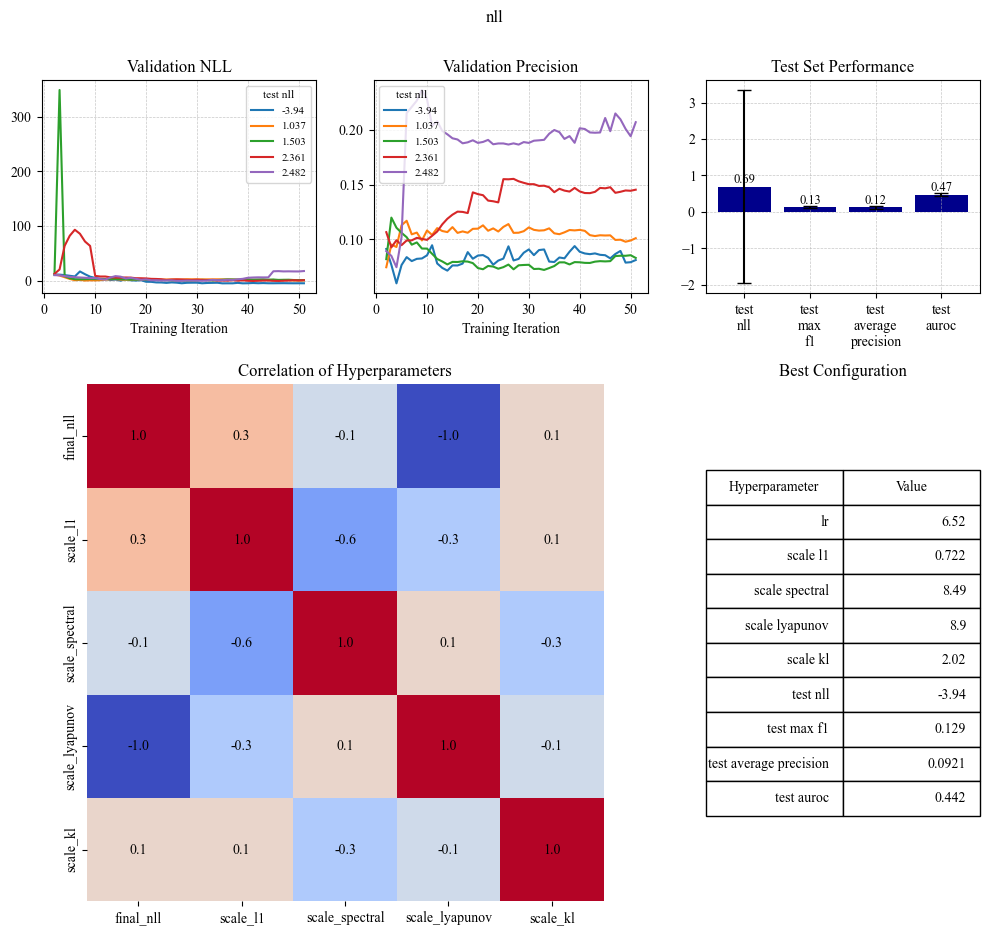

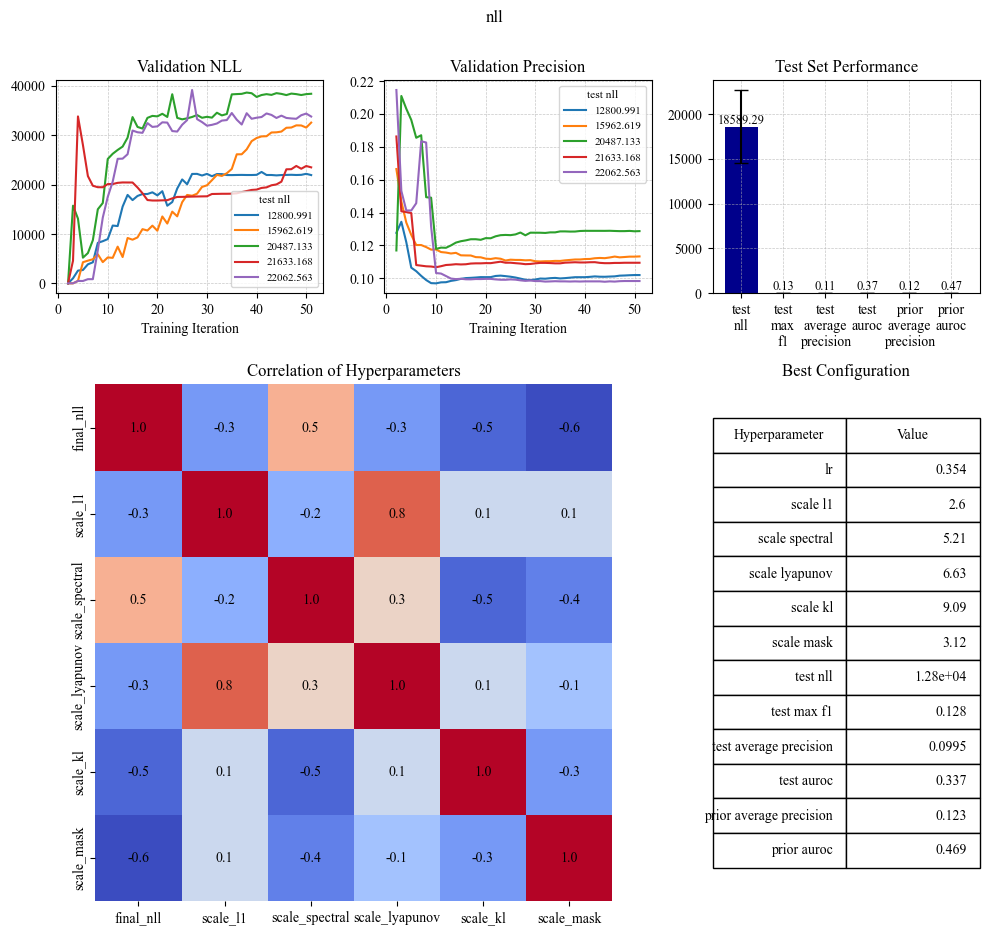

In [65]:
#fig, ax = plt.subplots(nrows=len(params))
n_runs = 5
for n, id in enumerate(params.index):
    fig, df = plot_tune_run(results[id], id=id, n_runs=n_runs, 
                            metric="final_"+params.loc[id, "metric"],
                            table_scale=(1,2),
                            figsize=(10,10)
                            )
    fig.suptitle(params.loc[id, "metric"])
    fig.show()
    if save:
        p = f"./presentation/{id}_tune_result"
        print(f"Saving!! to {p}")
        fig.savefig(p+".pdf")
        df.to_csv(p+".csv")
    
    

In [47]:
params

,model_n_genes,model_n_samples,scale_mask,grn_noise_p,n_epochs,use_hard_mask,masking_mode,bin_prior,data_source,mask_precision,metric,masking_loss
tuner_run_007,10,8000,1,NaN,5000,False,NaN,False,create_data,NaN,nll,False
tuner_run_012,10,8000,1,0.0,5000,False,loss,False,create_data_scMultiSim,0.12810439560439563,nll,True


/tmp/ipykernel_1693379/922733499.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  result = pd.read_json(rf.readline())
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: Fu

Saving!
Saving!! to ./presentation/tuner_run_007_tune_best_run


/tmp/ipykernel_1693379/922733499.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  result = pd.read_json(rf.readline())
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: Fu

Saving!
Saving!! to ./presentation/tuner_run_012_tune_best_run


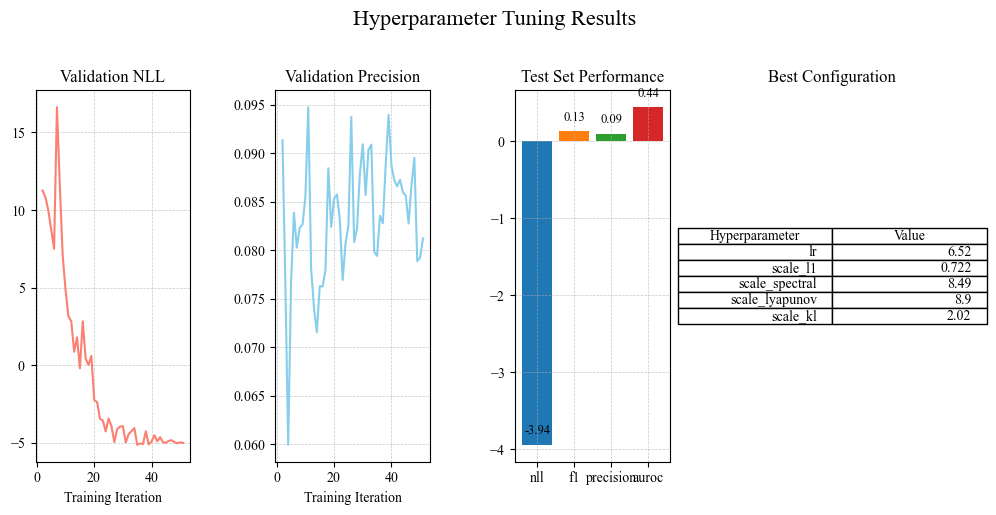

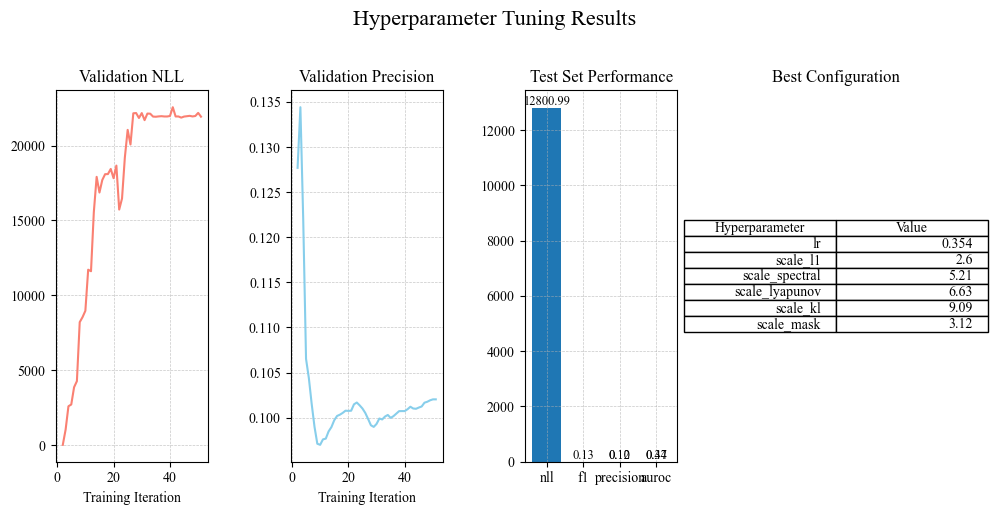

In [48]:
for id in params.index:
    data = results[id].sort_values("final_"+params.loc[id, "metric"], ascending=True).iloc[0]
    fig = plot_training(data, id=id, table_scale=(2,1), figsize=(10,5))
    fig.tight_layout()
    if save:
        print("Saving!")
        p = f"./presentation/{id}_tune_best_run"
        print(f"Saving!! to {p}")
        fig.savefig(p+".pdf")
        df.to_csv(p+".csv")

In [49]:

columns = []
for d in results.values():
    if len(d.columns) > len(columns):
        columns = list(d.columns)

best_results = pd.DataFrame(columns=columns+["run_id", param_of_interest])
for id in params.index:
    
    r = results[id].sort_values("final_"+params.loc[id, "metric"], ascending = params.loc[id, "metric"]=="nll").iloc[:n_runs]
    r[param_of_interest] = np.full(n_runs,[params.loc[id, param_of_interest]])
    r["run_id"] = np.full(n_runs,id)
    missing = [m for m in best_results.columns if m not in r.columns]
    print(f"missing: {missing}")
    r[missing] = np.full((n_runs, len(missing)), None)
    best_results = pd.concat([best_results, r], axis=0)
best_results


missing: ['scale_mask', 'prior_average_precision', 'prior_auroc']
missing: []


/tmp/ipykernel_1693379/1151925747.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  best_results = pd.concat([best_results, r], axis=0)
/tmp/ipykernel_1693379/1151925747.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  best_results = pd.concat([best_results, r], axis=0)


,final_nll,final_max_f1,final_average_precision,final_auroc,nll,average_precision,avg_valid_loss,timestamp,done,training_iteration,...,lr,scale_l1,scale_spectral,scale_lyapunov,scale_kl,scale_mask,prior_average_precision,prior_auroc,run_id,masking_loss
d5f03614,-3.940261,0.129032,0.092118,0.441576,-5.008591,0.081220,-2.322977,1753571947,False,52,...,6.522782,0.722286,8.488683,8.901929,2.018764,NaN,NaN,NaN,tuner_run_007,False
41580a7f,1.036867,0.105263,0.103080,0.486413,0.310491,0.101178,-2.922037,1753595393,False,52,...,8.168666,8.214858,2.783047,6.932356,1.600121,NaN,NaN,NaN,tuner_run_007,False
c6955eed,1.503377,0.136364,0.077653,0.444293,0.785606,0.083141,-3.058454,1753583119,False,52,...,6.256908,5.225409,9.980510,6.110407,0.288314,NaN,NaN,NaN,tuner_run_007,False
7b1f80f2,2.361344,0.173913,0.152915,0.544837,0.657182,0.145458,-2.882906,1753575381,False,52,...,7.284054,9.945211,5.391991,4.071783,6.677954,NaN,NaN,NaN,tuner_run_007,False
c792caad,2.482139,0.119403,0.189381,0.425272,17.391592,0.207081,-2.500709,1753572496,False,52,...,8.077432,3.174122,7.261609,2.695916,1.766144,NaN,NaN,NaN,tuner_run_007,False
c8acd696,12800.990651,0.127660,0.099518,0.336870,21931.117755,0.102027,3.179845,1754047755,False,52,...,0.353541,2.595212,5.205480,6.628598,9.094111,3.123994,0.123419,0.469054,tuner_run_012,True
2144eea6,15962.619430,0.166667,0.110968,0.401415,32549.394981,0.113357,3.714086,1754054286,False,52,...,1.196269,7.454250,3.579886,6.817195,3.524442,5.647489,0.123419,0.469054,tuner_run_012,True
93f843f4,20487.132877,0.135593,0.128156,0.417330,38384.738966,0.128754,3.812351,1754042745,False,52,...,3.751656,7.322619,1.568385,5.990598,9.507636,1.568626,0.123419,0.469054,tuner_run_012,True
3b97cfed,21633.168067,0.105263,0.109542,0.391689,23494.113168,0.109502,3.417600,1754059434,False,52,...,2.860828,7.421636,7.072396,9.132753,5.708310,0.802377,0.123419,0.469054,tuner_run_012,True
1badfded,22062.563361,0.131148,0.098597,0.325376,33780.940609,0.098394,3.828872,1754045049,False,52,...,8.326102,1.826431,5.252317,1.842211,2.131268,3.049380,0.123419,0.469054,tuner_run_012,True


In [50]:
params

,model_n_genes,model_n_samples,scale_mask,grn_noise_p,n_epochs,use_hard_mask,masking_mode,bin_prior,data_source,mask_precision,metric,masking_loss
tuner_run_007,10,8000,1,NaN,5000,False,NaN,False,create_data,NaN,nll,False
tuner_run_012,10,8000,1,0.0,5000,False,loss,False,create_data_scMultiSim,0.12810439560439563,nll,True


In [51]:
def bar_scientific(df, param_of_interest, ax, colors = ['skyblue', 'salmon'], bar_width = 0.35, annotate = True, a = 0.05, legends = True, capsize=4):
    metrics = df.columns.drop(param_of_interest)
    x = np.arange(len(metrics))
    
    unique_df = list(set(df[param_of_interest]))
    p_dict = {}
    for i, metric in enumerate(metrics):
        vals = {}
        means = {}
        stds = {}
        x_pos = {}
        for n, v in enumerate(unique_df):
            values = df[df[param_of_interest] == v][metric].astype(float)
            vals[v] = values
            means[v], stds[v] = values.mean(), values.std()
            # Bar positions
            x_pos[v] = x[i] + bar_width * n + i*(bar_width*len(unique_df))
            # Plot bars
            if annotate:
                ax.text(x_pos[v], 0, np.round(means[v], 3), ha = "center")
            ax.bar(x_pos[v], means[v], yerr=stds[v], capsize=capsize, width=bar_width, color=colors[n], label=v if i == 0 else "")
        
        # Significance test
        tested = []
        for p1, v1 in vals.items():
            for p2, v2 in vals.items():
                if p1==p2 or (p1,p2) in tested or (p2,p1) in tested:
                    continue
                else:
                    tested.append((p1,p2))
        
                _, p_val = ttest_ind(v1, v2, equal_var=False)

                # Define significance level
                if  p_val < a:
                    sig = "*"
                    sig += "".join(["*" for n in np.logspace(-2, -5, num=4) if p_val<n])
                    p_dict[f"{metric}: {p1}, {p2}"] = p_val

                else:
                    sig = False

                if sig:
                    # Draw annotation line
                    y_max = np.max(list(means.values())) + bar_width/2
                    ax.plot(np.repeat([x_pos[p1], x_pos[p2]], 2), [y_max-bar_width/10,y_max, y_max, y_max-bar_width/10], color='black', linewidth=1)
                    ax.text((x_pos[p1] + x_pos[p2])/2, y_max + 0.01, sig, ha='center', va='bottom', fontsize=12)

    # Final layout
    print(f"Significant p-values: {p_dict}")
    if len(metrics) >1:
        x=ax.get_xticks()
        ax.set_xticks(np.linspace(x[1], x[-2], len(metrics)),[m.replace("_", "\n").replace("final", "test").capitalize() for m in metrics])
            #x/np.max(x)*ax.get_xticks()[-3] + bar_width/2, 
    else:
        ax.set_xticks([np.median(ax.get_xticks())], [metrics[0].replace("_", " ").replace("final", "test").capitalize()])
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_ylabel("Score")
    if legends:
        ax.legend(loc = "upper right", title = param_of_interest.replace("_", " "))
    return p_dict



['final_nll']
Significant p-values: {'final_auroc: True, False': np.float64(0.010947300767892881)}
Significant p-values: {'final_nll: True, False': np.float64(0.0005040788095053575)}
sorting metric: final_nll to minimize: True


/tmp/ipykernel_1693379/922733499.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  result = pd.read_json(rf.readline())
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: Fu

/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarnin

['final_nll', 'final_max_f1', 'final_average_precision', 'final_auroc']
sorting metric: final_nll to minimize: True


/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_1693379/922733499.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  result = pd.read_json(rf.readline())
/tmp/ipykernel_1693379/922733499.py:11: Fu

['final_nll', 'final_max_f1', 'final_average_precision', 'final_auroc', 'prior_average_precision', 'prior_auroc']
Saving!
Saving!! to ./presentation/compare_masking_loss_mask_nan_metric_final_nll


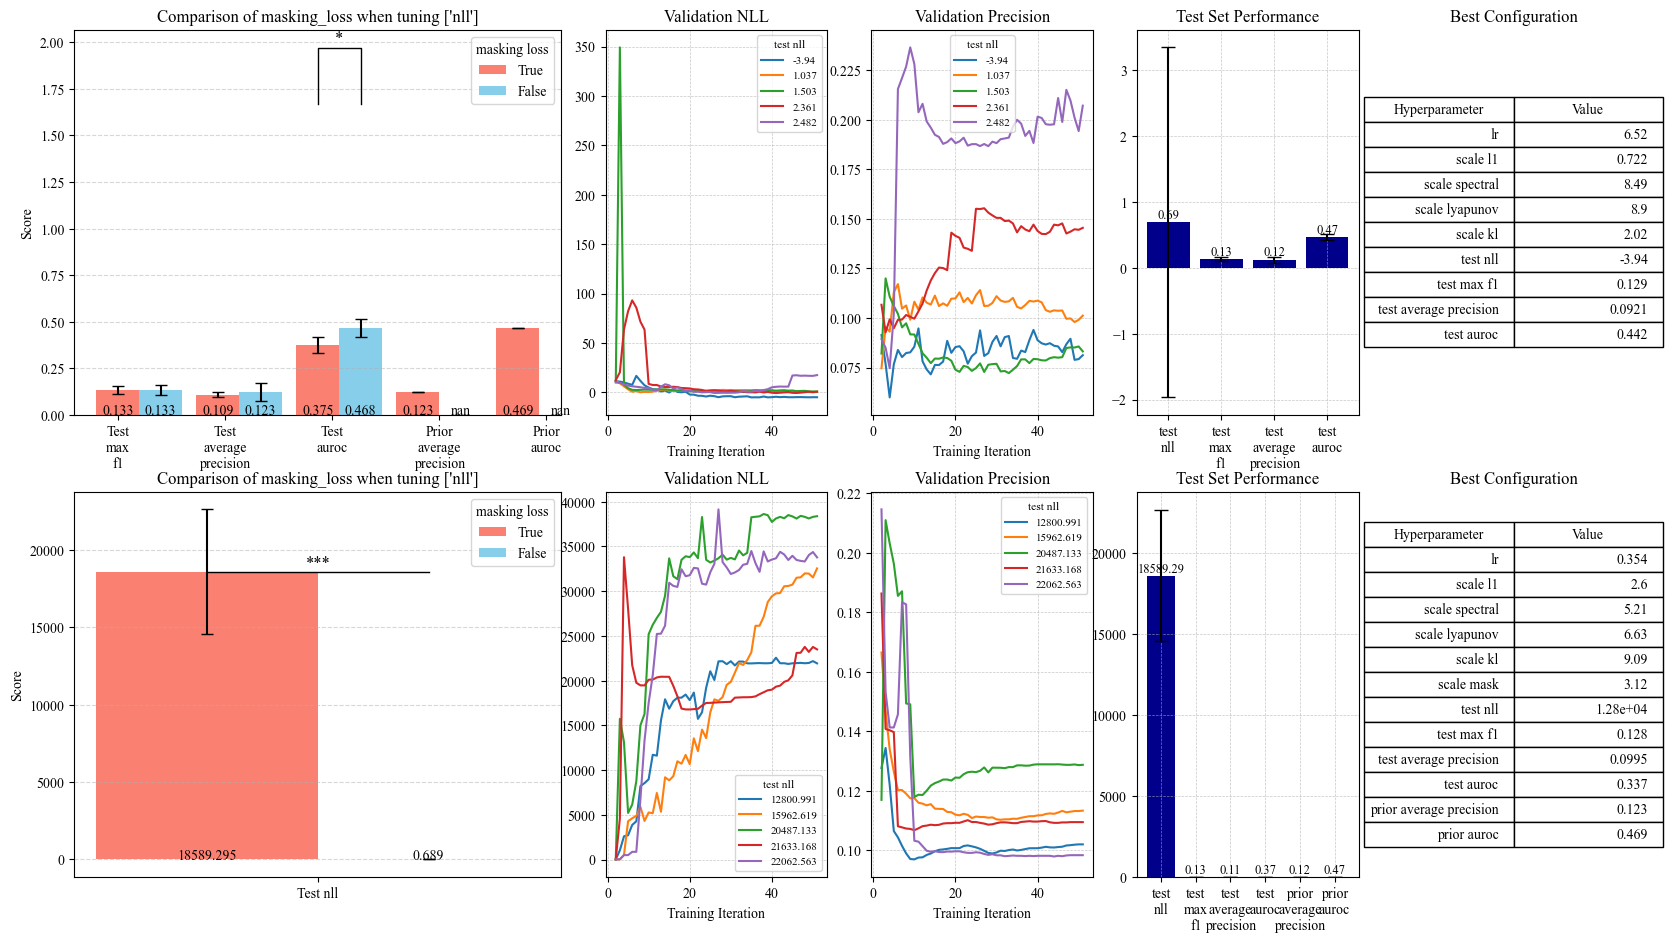

In [52]:
fig = plt.figure(figsize=(20,11))
gs = GridSpec(nrows=len(params), ncols=6)
colors = ["salmon", "skyblue"]
metrics = ["final_nll", "final_max_f1", "final_average_precision", "final_auroc"]
if (params["masking_mode"] == "loss").any():
    metrics.append("prior_average_precision")
    metrics.append("prior_auroc")
metrics1 = metrics[1:]
metrics2 = [metrics[0]]
print(metrics2)
bar_ax1 = fig.add_subplot(gs[0, :2])
bar_ax2 = fig.add_subplot(gs[1, :2])
p_dict = bar_scientific(best_results[metrics1+[param_of_interest]], param_of_interest=param_of_interest, ax=bar_ax1, colors=colors, annotate=True, bar_width=3, capsize=4)
bar_ax1.set_title(f"Comparison of {param_of_interest} when tuning {list(set(params["metric"].values))}")

p_dict.update(bar_scientific(best_results[metrics2+[param_of_interest]], param_of_interest=param_of_interest, ax=bar_ax2, colors=colors, annotate=True, bar_width=3, capsize=4))
bar_ax2.set_title(f"Comparison of {param_of_interest} when tuning {list(set(params["metric"].values))}")

for n, run_id in enumerate(params.index):
    metric = "final_"+params.loc[run_id, "metric"]
    print(f"sorting metric: {metric} to minimize: {metric =="final_nll"}")
    axes = [fig.add_subplot(gs[n,2+x]) for x in range(4)]
    plot_tune_run(df = results[run_id],metric = metric, axes=axes, id = run_id, corr_analysis=False, min=metric =="final_nll", table_scale=(1.35,1.5), n_runs=n_runs)

if save:
    print("Saving!")
    p = f"./presentation/compare_{param_of_interest}_mask_{params["masking_mode"].iloc[0]}_metric_{metric}"
    print(f"Saving!! to {p}")
    fig.savefig(p+".pdf")
    best_results.to_csv(p+".csv")

In [53]:
p_dict

{'final_auroc: True, False': np.float64(0.010947300767892881),
 'final_nll: True, False': np.float64(0.0005040788095053575)}

In [54]:
save=False